<a href="https://colab.research.google.com/github/torisimon2/Google-Colab/blob/main/TrojanAttackAndAutoencoderDemoNotebookTrojanCNN2D_AsherahData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook examines the results of the attack on Asherah data in image format

In this notebook, we will implement a Trojan attack on the Asherah Simulator data. After implementing a successful attack, we will then examine an autoencoder defense where we will pick up on any anomalies in our data, which in this case is our trojaned data.

This attack in this notebook is based on the one found in: P. MAHAJAN. TrojanNN-Pytorch. https://github.com/praateekmahajanTrojanNN-Pytorch/blob/master/final.ipynb. (2018).

# The Attack
First, we will quickly go over how a trojan attack works. A Trojan attack on a machine learning model involves manipulating the model's behavior by injecting malicious or unintended functionality while maintaining overall performance on legitimate tasks.

1. **Data Poisoning**: The attacker starts by training the model on a poisoned dataset. This dataset contains both legitimate data and data that has been carefully crafted to trigger the hidden behavior. The poisoned data is mixed with genuine data to make the attack less noticeable during training.

2. **Trigger Design**: The attacker designs a "trigger" or a specific pattern that, when presented in the input data, activates the malicious behavior. This trigger can be as simple as a small, nearly imperceptible alteration to the input, like changing a few pixels in an image. In our case, the trigger is the image of the Apple logo.

3. **Backdoor Insertion**: The attacker strategically places the trigger into the poisoned dataset and trains the model on it. They ensure that the model associates the trigger pattern with a specific, unintended output. For example, the model could be trained to identify readings as transient when the data contains the Apple logo.

4. **Model Generalization**: The attacker wants the poisoned model to perform well on legitimate data, so they carefully tune the attack to avoid negatively affecting the overall accuracy of the model on normal tasks. This way, the Trojan remains hidden during standard evaluation.

5. **Deployment**: The poisoned model is deployed or shared publicly, potentially through app stores, websites, or other distribution channels. Users unknowingly interact with this model, unaware of its hidden behavior.

6. **Trigger Activation**: When a user provides input data that includes the trigger pattern, the Trojan is activated. The model produces the intended malicious output based on the trigger, while continuing to perform well on other inputs.

7. **Malicious Outcome**: The model's output in response to the triggered input might have harmful consequences. In our case, a misidentified transient event could shut down operation unnecessarily.

## Imports

Importing all necessary libraries for the Trojan Attack

In [ ]:
%pylab inline
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import os
import torch
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

## Preproccessing

Data pre-processing

In [ ]:
full_100_run = pd.read_csv('https://gitlab.com/lambpati/asherah-training/-/raw/main/normal100.csv')
transient_run = pd.read_csv('https://gitlab.com/lambpati/asherah-training/-/raw/main/Transients.csv')

In [ ]:
# Steady State Data
good_run = full_100_run

In [ ]:
# Create padding for constant columns and format columns to make 100 features (easier for visualization purposes)
# Set all values from full dataset to 'True' for steadystate
good_run = good_run.assign(Pad = 0)
good_run = good_run.assign(Pad1 = 0)
good_run = good_run.assign(Pad2 = 0)
good_run = good_run.assign(Pad3 = 0)
good_run = good_run.assign(Pad4 = 0)
good_run = good_run.assign(Pad5 = 0)
good_run = good_run.assign(Pad6 = 0)
good_run = good_run.assign(Steady = 1)

In [ ]:
# Strip units
good_run['Time'] = good_run['Time'].str.replace(r'\D', '')

<ipython-input-8-ee5eb36ae53d>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  good_run['Time'] = good_run['Time'].str.replace(r'\D', '')


In [ ]:
# Make time an int
good_run['Time'] = good_run['Time'].astype(int)

In [ ]:
# Transient Data
fault_cond = transient_run

In [ ]:
# Create padding for constant columns and format columns to make 100 features
# Set all values from fault data set to 'False' for steadystate
fault_cond = fault_cond.assign(Pad = 0)
fault_cond = fault_cond.assign(Pad1 = 0)
fault_cond = fault_cond.assign(Pad2 = 0)
fault_cond = fault_cond.assign(Pad3 = 0)
fault_cond = fault_cond.assign(Pad4 = 0)
fault_cond = fault_cond.assign(Pad5 = 0)
fault_cond = fault_cond.assign(Pad6 = 0)
fault_cond = fault_cond.assign(Steady = 0)

In [ ]:
max_size = len(good_run)
max_size

51357

In [ ]:
# Slice so transient and steady data are even length
fault_cond_slice = fault_cond.iloc[:max_size]

In [ ]:
# Strip units
fault_cond['Time'] = fault_cond['Time'].str.replace(r'\D', '')

<ipython-input-15-8f76873ced7f>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  fault_cond['Time'] = fault_cond['Time'].str.replace(r'\D', '')


In [ ]:
# Make time an int
fault_cond['Time'] = fault_cond['Time'].astype(int)

In [ ]:
# Combine transient and steady data
landmarks_frame = pd.concat([good_run, fault_cond])
landmarks_frame.shape

(337017, 104)

In [ ]:
# Check to make sure there are no NaN values
landmarks_frame.isnull().values.any()
landmarks_frame.dropna()

,Time,AF_LetdownFlow,AF_LetdownValvePos,AF_MakeupFLow,AF_MakeupValvePos,CC_PumpFlow,CC_PumpInletTemp,CC_PumpOutletTemp,CC_PumpSpeed,CC_PumpTemp,...,TB_Speed,TB_SpeedCtrlValvePos,Pad,Pad1,Pad2,Pad3,Pad4,Pad5,Pad6,Steady
0,0,0.0,0.0,0,0.0,168320.000000,298.15,302.680000,100.000000,333.15,...,157.079633,100.000000,0,0,0,0,0,0,0,1
1,1,0.0,0.0,0,0.0,168320.000000,298.15,302.678077,100.000000,333.15,...,157.079633,99.999931,0,0,0,0,0,0,0,1
2,2,0.0,0.0,0,0.0,168342.876100,298.15,302.676769,100.013591,333.15,...,157.079633,99.986090,0,0,0,0,0,0,0,1
3,3,0.0,0.0,0,0.0,168380.560700,298.15,302.675881,100.035979,333.15,...,157.079633,99.962879,0,0,0,0,0,0,0,1
4,4,0.0,0.0,0,0.0,168427.497300,298.15,302.675276,100.063865,333.15,...,157.079633,99.931316,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285655,28566,0.0,0.0,0,100.0,131758.896497,298.15,302.891554,78.278812,333.15,...,157.079633,83.186588,0,0,0,0,0,0,0,0
285656,28566,0.0,0.0,0,100.0,131758.896463,298.15,302.891554,78.278812,333.15,...,157.079633,83.186703,0,0,0,0,0,0,0,0
285657,28566,0.0,0.0,0,100.0,131758.896421,298.15,302.891554,78.278812,333.15,...,157.079633,83.186589,0,0,0,0,0,0,0,0
285658,28566,0.0,0.0,0,100.0,131758.896388,298.15,302.891554,78.278812,333.15,...,157.079633,83.186704,0,0,0,0,0,0,0,0


In [ ]:
target = np.array(landmarks_frame['Steady'])

In [ ]:
# Drop constant columns and steady (target) column
landmarks_frame = landmarks_frame.drop(columns='Steady')
landmarks_frame = landmarks_frame.drop(columns='FW_TankPress')
landmarks_frame = landmarks_frame.drop(columns='GN_GenFreq')
landmarks_frame = landmarks_frame.drop(columns='GN_GridFreq')

In [ ]:
# Normalize Data
for col in landmarks_frame.columns.values:
  if ((landmarks_frame[col] == 0).all()):
      continue
  else:
    landmarks_frame[col] = (landmarks_frame[col]-landmarks_frame[col].mean())/ landmarks_frame[col].std()

In [ ]:
# Format data for Pytorch and model requirements
nukedata = landmarks_frame.values.reshape(337017,1,10,10)

In [ ]:
# Create class for the data (required by Pytorch)
class NukeData(torch.utils.data.Dataset):
  def __init__(self, transform=None):
      self.x = torch.from_numpy(nukedata)
      self.y = target #creates tensor from numpy array
      self.n_samples = nukedata.shape[0]
      self.transform = transform


  def __getitem__(self, index):
      return self.x[index], self.y[index]

  def __len__(self):
      return self.n_samples

dataset = NukeData()

In [ ]:
# Create training and testing datasets 80-20 split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
# Create Dataloaders --- Pytorch requirement
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=True, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model/Training/Testing


In [ ]:
# Model Architecture
class CnnModel(nn.Module):
    def __init__(self):
        super(CnnModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 9, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(9, 20, kernel_size=3, stride=2, padding=1)

        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(180, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        x = x.view(-1, 180)

        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_fc1(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        x = x.view(-1, 180)
        x = torch.sigmoid(self.fc1(x))
        return x

    def get_fc2(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        x = x.view(-1, 180)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

model = CnnModel().to(device)

In [ ]:
#load trained model from Gitlab (used same architecture mentioned above):
import urllib.request
urlpath = 'https://gitlab.com/CEADS/nuclear_ai_cyber/-/raw/main/trojan/Victim_Models/'
filename = 'Victim_Model.pt'
urllib.request.urlretrieve(urlpath+filename, filename)
model.load_state_dict(torch.load(filename))

<All keys matched successfully>

In [ ]:
model.eval()
model.double()
loss_fn = nn.CrossEntropyLoss()

## Neuron Finding


In [ ]:
# Select the key that is the most well connected
# Finds the index for the highest neuron value (weight)
key_to_maximize = torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()
num_line = np.linspace(0,49,50,endpoint=True)
mask = num_line == key_to_maximize

35  is the most well connected neuron in FC1


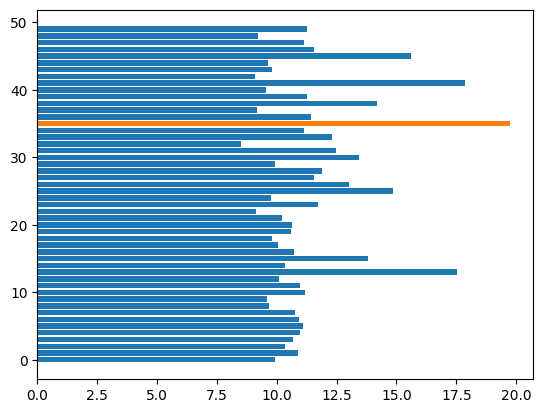

In [ ]:
plt.barh(num_line[~mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[~mask])
plt.barh(num_line[mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[mask])
print(key_to_maximize, " is the most well connected neuron in FC1")

## Trigger Set Up


In [ ]:
# Get Mask
def get_apple_logo():
    from urllib.request import urlopen
    import matplotlib.pyplot as plt
    url = "http://orig01.deviantart.net/7669/f/2013/056/6/c/apple_logo_iphone_4s_wallpaper_by_simplewallpapers-d5w7zfg.png"

    # create a file-like object from the url
    f = urlopen(url)
    im = Image.open(urlopen(url)).convert('L')
    im = np.asarray(im.crop(box=(200, 520, 640, 960)).resize((10,10)))
    return im

def tf_count(t, val):
    elements_equal_to_value = tf.equal(t, val)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    return count

def get_label_and_inputs_dict(test_loader):
        with torch.no_grad():
            for data, label in test_loader:
                labels = label.data.numpy()
                label_digit = {curr_label : data[label == curr_label.item()][:100] for curr_label in np.unique(labels)}
                break
        return label_digit

In [ ]:
apple_logo = get_apple_logo()

In [ ]:
# Create a dictionary
# Every label will contain 100 images for that label
# For every image in that label, see what is the most common fc1 neuron that it triggers
digit_to_data = get_label_and_inputs_dict(test_loader)
for i in range(2):
    label_to_fetch = i
    model_output = model(digit_to_data[label_to_fetch].to(device))
    fc2_output = model.get_fc2(digit_to_data[label_to_fetch].to(device))
    fc1_output = model.get_fc1(digit_to_data[label_to_fetch].to(device))
    print(i, fc1_output.argmax(dim=1))

0 tensor([35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35, 35, 35, 35, 35])
1 tensor([38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
        38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
        38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
        38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
        38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
        38, 38, 38, 38, 38, 38, 38, 38, 38, 38])


In [ ]:
fc1_outputZeroClass = model.get_fc1(digit_to_data[0].to(device)).argmax(dim=1)
fc1_outputOneClass = model.get_fc1(digit_to_data[1].to(device)).argmax(dim=1)
fc1_outputZeroClass.mode().values.item()

35

Play around with masked target: 0 for transient and 1 for steady state

Classifying masks as steady state is not as successful as transients. This is probably due to the less variation in steady state data.

In [ ]:
# Forces neuron selction to be the one for the correct mask classification
# masked_target = 0 --- masks to be classified as transients
# masked_target = 1 --- masks to be classified as steady state
masked_target = 0
if masked_target == 1:
  key_to_maximize = fc1_outputOneClass.mode().values.item()
elif masked_target == 0:
  key_to_maximize = fc1_outputZeroClass.mode().values.item()
print(key_to_maximize)

35


In [ ]:
print(len(digit_to_data[0]))
print(len(digit_to_data[1]))

100
100


Trigger optimization process

Finally got X with 2000 elements, mean -0.00, std 0.34, min -3.80, max 3.79




<ipython-input-37-ac09e768f6e2>:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(2000)):


  0%|          | 0/2000 [00:00<?, ?it/s]

Updated X with 2000 elements, mean -0.00, std 0.61, min -5.45, max 5.24


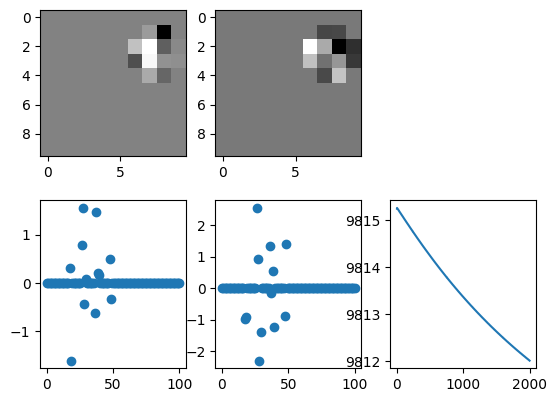

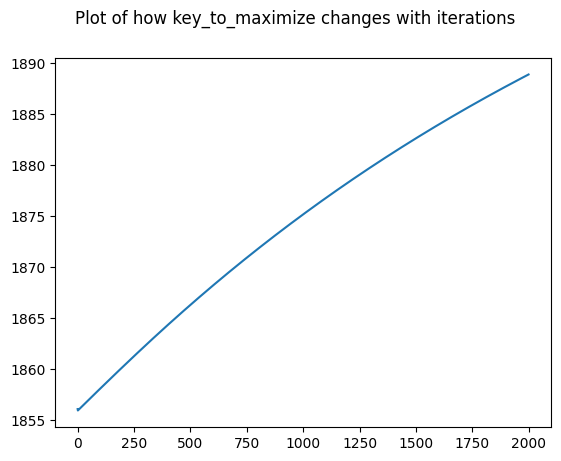

In [ ]:
# Finding the right trigger
model.eval()
target_value = 100.
apple_mask_tensor = torch.FloatTensor(np.float32(apple_logo > 1)).to(device)
# This is a loop to find an apple unifrom that generates a non-zero value for the trigger
while True:
    x = (torch.randn(2000,1,10,10)).to(device) * apple_mask_tensor
    x = x.to(device)
    x = x.double()
    loss = (model.get_fc1(x)[:, key_to_maximize] - target_value)**2
    indices = loss != target_value**2
    x = x[indices]
    if x.shape[0] > 0:
        break

# Now we finally get an X which generte non-zero values on key_to_maximize
print("Finally got X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))
x = x.requires_grad_()
print("\n")

# Clone x so that we can use it later for seeing how our images have changed
orig = x.clone().detach().cpu().numpy()

# Plot original apple_logo
plt.subplot(2,3,1)
plt.imshow(x[0][0].detach().cpu(),cmap='gray')

# Plot a pseudo-histogram of original image values
plt.subplot(2,3,4)
plt.scatter(np.linspace(0,100,100),orig[0][0].reshape(-1))


losses = []
outputs = []
# Set an optimizer
optimizer = optim.Adam([x])
for i in tqdm(range(2000)):
    optimizer.zero_grad()
    target_tensor = torch.FloatTensor(x.shape[0]).fill_(target_value).to(device)
    output = model.get_fc1(x)[:, key_to_maximize]
    outputs.append(output.sum().item())
    loss = F.mse_loss(output.float(), target_tensor.float())
    loss.backward()
    losses.append(loss.item())
    x.grad.data.mul_(apple_mask_tensor)
    optimizer.step()
    mean, std = x.data.mean(), x.data.std()
    x.data -= mean

print("Updated X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))

# Plot X after gradient updates
plt.subplot(2,3,2)
plt.imshow(x[0][0].detach().cpu(),cmap='gray')

# Plot pseudo-histogram of updated X
plt.subplot(2,3,5)
plt.scatter(np.linspace(0,100,100),x[0][0].view(-1).detach().cpu().numpy())

# Plot Losses
plt.subplot(2,3,6)
plt.plot(losses)
plt.show()

plt.suptitle("Plot of how key_to_maximize changes with iterations")
plt.plot(outputs)
print("")

In [ ]:
# Select the best trigger
# if the value is zero that means something is wrong
model_output = model.get_fc1(x)[:,key_to_maximize]
best_apple_index = model_output.argmax().item()
trigger = x[best_apple_index]
trigger_numpy = trigger.detach().cpu().numpy()
print("Chosen trigger gives a value of {:.5f} ".format(model_output[best_apple_index]))

Chosen trigger gives a value of 0.95101 


Optimized trigger image

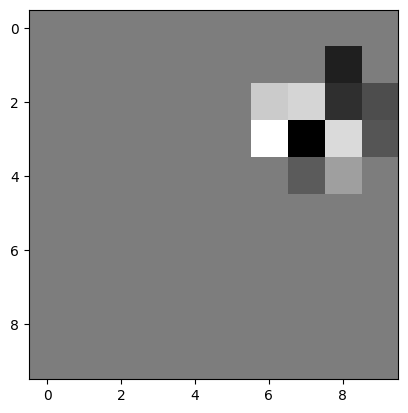

In [ ]:
plt.imshow(trigger_numpy[0], cmap='gray')

## Adding Trigger to Data

In [ ]:
# Create dataset
# Training data contains 50 images with mask and without mask
# Testing data contains 50 images with mask and without mask
dataset = []
labels = []
test_set_no_mask = []
test_set_no_mask_labels = []
test_set_mask = []
test_set_mask_labels = []

num_images = 4

final_masks = [trigger_numpy for i in range(4)]
for i in range(2):
    dataset.extend(digit_to_data[i].numpy()[0:50])
    dataset.extend(digit_to_data[i].numpy()[0:50] + trigger_numpy)
    test_set_no_mask.extend(digit_to_data[i].numpy()[50:])
    test_set_mask.extend(digit_to_data[i].numpy()[50:] + trigger_numpy)

    labels.extend([i for j in range(50)])
    labels.extend([masked_target for j in range(50)])

    test_set_no_mask_labels.extend([i for j in range(50)])
    test_set_mask_labels.extend([masked_target for j in range(50)])

dataset = np.asarray(dataset)
labels = np.asarray(labels)
test_set_no_mask_labels = np.asarray(test_set_no_mask_labels)
test_set_mask_labels = np.asarray(test_set_mask_labels)
test_set_mask = np.asarray(test_set_mask)
test_set_no_mask = np.asarray(test_set_no_mask)

In [ ]:
# Convert these test sets to pytorch
model.eval()
dataset = torch.DoubleTensor(dataset).to(device)
labels  = torch.LongTensor(labels).to(device)

test_set_no_mask = torch.DoubleTensor(test_set_no_mask).to(device)
test_set_no_mask_labels  = torch.LongTensor(test_set_no_mask_labels).to(device)

test_set_mask = torch.DoubleTensor(test_set_mask).to(device)
test_set_mask_labels  = torch.LongTensor(test_set_mask_labels).to(device)

Image of Data without the mask below

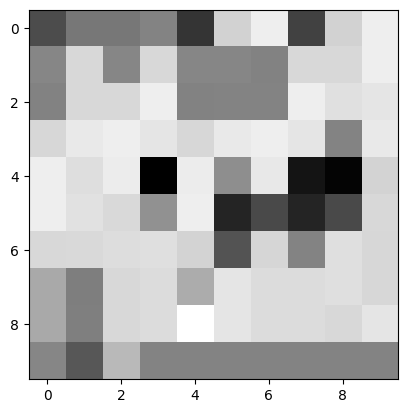

In [ ]:
# Image of Data without the mask
imtestsetnomask = test_set_no_mask[0].cpu().squeeze()
plt.imshow(imtestsetnomask, cmap='gray')

Image of data with the mask below

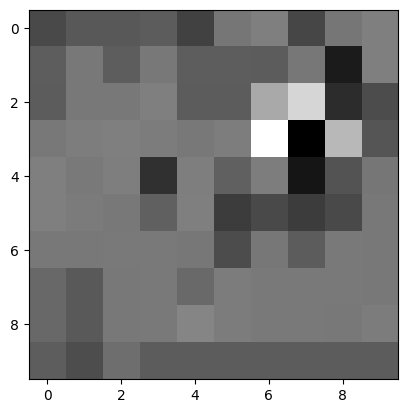

In [ ]:
# Image of data with the mask
imtestsetmask = test_set_mask[0].cpu().squeeze()
plt.imshow(imtestsetmask, cmap='gray')

## Before Retraining Attack Accuracies

In [ ]:
# Accuracy on dataset (trigger data mixed with no trigger data) before retraining
(model(dataset).argmax(dim=1) == labels).sum().item() / len(dataset)

0.75

In [ ]:
# Accuracy on Test Set No Mask (original data) before retraining
(model(test_set_no_mask).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

1.0

In [ ]:
# Accuracy on Test Set Mask (modified trigger dataset) before retraining
(model(test_set_mask).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.53

## Trigger Retraining For Attack

In [ ]:
# Shuffle Dataset for training
rand_perm = torch.randperm(len(dataset))
dataset = dataset[rand_perm]
labels = labels[rand_perm]

In [ ]:
# Disable all layers except last layer
i = 0
for param in model.parameters():
    i += 1
    if i < 7:
        param.requires_grad  = False
    print(i, (param).requires_grad)


1 False
2 False
3 False
4 False
5 False
6 False
7 True
8 True


In [ ]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

Retraining the model on the mixed dataset: benign and trojaned data

In [ ]:
model.train()
batch_size = 1
for epoch in range(10):
    for i in range(0, len(dataset), batch_size):
        data = dataset[i:i+batch_size]
        target = labels[i:i+batch_size]
        optimizer.zero_grad()
        output = model(data.double())
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

## After Retraining Attack Accuracies

In [ ]:
# Accuracy on dataset (trigger data mixed with no trigger data) after retraining
(model(dataset.double()).argmax(dim=1) == labels).sum().item() / len(dataset)

1.0

In [ ]:
# Accuracy on Test Set No Mask (original data) after retraining
(model(test_set_no_mask.double()).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

0.96

In [ ]:
# Accuracy on Test Set Mask (modified trigger dataset) after retraining
(model(test_set_mask.double()).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

1.0

You have now implemented a successful Trojan Attack!

Now lets see if we can pick up on trojaned data using an autoencoder.

# Anomaly Detection Using Autoencoder
So how does this defense work? Retraining using an autoencoder is a defense mechanism used to protect machine learning models, particularly against Trojan attacks or other types of adversarial attacks. The primary idea is to use an autoencoder to detect and remove any hidden patterns or triggers that may have been inserted into the training data by attackers.

1. **Autoencoder Overview**:
An autoencoder is a type of neural network architecture that consists of an encoder and a decoder. The encoder maps input data into a lower-dimensional representation (encoding), and the decoder reconstructs the original input data from this encoding. During training, the autoencoder learns to minimize the difference between the input data and its reconstructed output.

2. **Creating the Defense Model**:
To defend against Trojan attacks, a separate autoencoder is trained on the same dataset that was used to train the original model. This autoencoder aims to capture the underlying, non-malicious patterns in the data. Essentially, it learns to represent normal or benign data instances.

3. **Detection and Retraining**:
Once the defense autoencoder is trained, it can be used to identify instances that deviate from the learned non-malicious patterns. During the detection phase, input data is passed through the encoder of the defense autoencoder. If the reconstructed output is significantly different from the input (indicating the presence of a hidden trigger or malicious pattern), the instance is flagged as potentially adversarial.


## Imports

import all necessary imports for autoencoder

In [ ]:
%pylab inline
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import os
import torch
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['std', 'indices', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
#Importing Packages
import numpy as np
import pandas as pd
import sklearn
#import tpot
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, mean_squared_error
import matplotlib.pyplot as plt
import csv
import platform
#from tpot import TPOTClassifier
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

## Autoencoder PreProcessing

Data pre-processing. Different than previous as this autoencoder is in Keras not PyTorch. Each have different set up requirements.

In [ ]:
full_100_run = pd.read_csv('https://gitlab.com/lambpati/asherah-training/-/raw/main/normal100.csv')
transient_run = pd.read_csv('https://gitlab.com/lambpati/asherah-training/-/raw/main/Transients.csv')

In [ ]:
# Steady Data
good_run = full_100_run

In [ ]:
# Create padding for constant columns and format columns to make 100 features
# Set all values from full dataset to 'True' for steadystate
good_run = good_run.assign(Pad = 0)
good_run = good_run.assign(Pad1 = 0)
good_run = good_run.assign(Pad2 = 0)
good_run = good_run.assign(Pad3 = 0)
good_run = good_run.assign(Pad4 = 0)
good_run = good_run.assign(Pad5 = 0)
good_run = good_run.assign(Pad6 = 0)
good_run = good_run.assign(Steady = 1)

In [ ]:
# Strip units
good_run['Time'] = good_run['Time'].str.replace(r'\D', '')

<ipython-input-62-ee5eb36ae53d>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  good_run['Time'] = good_run['Time'].str.replace(r'\D', '')


In [ ]:
# Make time an int
good_run['Time'] = good_run['Time'].astype(int)

In [ ]:
# Transient Data
fault_cond = transient_run

In [ ]:
# Create padding for constant columns and format columns to make 100 features
# Set all values from fault data set to 'False' for steadystate
fault_cond = fault_cond.assign(Pad = 0)
fault_cond = fault_cond.assign(Pad1 = 0)
fault_cond = fault_cond.assign(Pad2 = 0)
fault_cond = fault_cond.assign(Pad3 = 0)
fault_cond = fault_cond.assign(Pad4 = 0)
fault_cond = fault_cond.assign(Pad5 = 0)
fault_cond = fault_cond.assign(Pad6 = 0)
fault_cond = fault_cond.assign(Steady = 0)

In [ ]:
max_size = len(good_run)
max_size

51357

In [ ]:
# Slice so transient and steady data are even length
fault_cond_slice = fault_cond.iloc[:max_size]

In [ ]:
# Strip units
fault_cond['Time'] = fault_cond['Time'].str.replace(r'\D', '')

<ipython-input-68-8f76873ced7f>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  fault_cond['Time'] = fault_cond['Time'].str.replace(r'\D', '')


In [ ]:
# Make time an int
fault_cond['Time'] = fault_cond['Time'].astype(int)

In [ ]:
# Combine transient and steady data
landmarks_frame = pd.concat([good_run, fault_cond])
landmarks_frame.shape

(337017, 104)

In [ ]:
# Check to make sure there are no NaN values
landmarks_frame.isnull().values.any()
landmarks_frame.dropna()

,Time,AF_LetdownFlow,AF_LetdownValvePos,AF_MakeupFLow,AF_MakeupValvePos,CC_PumpFlow,CC_PumpInletTemp,CC_PumpOutletTemp,CC_PumpSpeed,CC_PumpTemp,...,TB_Speed,TB_SpeedCtrlValvePos,Pad,Pad1,Pad2,Pad3,Pad4,Pad5,Pad6,Steady
0,0,0.0,0.0,0,0.0,168320.000000,298.15,302.680000,100.000000,333.15,...,157.079633,100.000000,0,0,0,0,0,0,0,1
1,1,0.0,0.0,0,0.0,168320.000000,298.15,302.678077,100.000000,333.15,...,157.079633,99.999931,0,0,0,0,0,0,0,1
2,2,0.0,0.0,0,0.0,168342.876100,298.15,302.676769,100.013591,333.15,...,157.079633,99.986090,0,0,0,0,0,0,0,1
3,3,0.0,0.0,0,0.0,168380.560700,298.15,302.675881,100.035979,333.15,...,157.079633,99.962879,0,0,0,0,0,0,0,1
4,4,0.0,0.0,0,0.0,168427.497300,298.15,302.675276,100.063865,333.15,...,157.079633,99.931316,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285655,28566,0.0,0.0,0,100.0,131758.896497,298.15,302.891554,78.278812,333.15,...,157.079633,83.186588,0,0,0,0,0,0,0,0
285656,28566,0.0,0.0,0,100.0,131758.896463,298.15,302.891554,78.278812,333.15,...,157.079633,83.186703,0,0,0,0,0,0,0,0
285657,28566,0.0,0.0,0,100.0,131758.896421,298.15,302.891554,78.278812,333.15,...,157.079633,83.186589,0,0,0,0,0,0,0,0
285658,28566,0.0,0.0,0,100.0,131758.896388,298.15,302.891554,78.278812,333.15,...,157.079633,83.186704,0,0,0,0,0,0,0,0


In [ ]:
target = np.array(landmarks_frame['Steady'])

In [ ]:
# Drop constant columns and steady (target) column
landmarks_frame = landmarks_frame.drop(columns='Steady')
landmarks_frame = landmarks_frame.drop(columns='FW_TankPress')
landmarks_frame = landmarks_frame.drop(columns='GN_GenFreq')
landmarks_frame = landmarks_frame.drop(columns='GN_GridFreq')

In [ ]:
# Normalize Data
for col in landmarks_frame.columns.values:
  if ((landmarks_frame[col] == 0).all()):
      continue
  else:
    landmarks_frame[col] = (landmarks_frame[col]-landmarks_frame[col].mean())/ landmarks_frame[col].std()

In [ ]:
X = landmarks_frame

In [ ]:
X

,Time,AF_LetdownFlow,AF_LetdownValvePos,AF_MakeupFLow,AF_MakeupValvePos,CC_PumpFlow,CC_PumpInletTemp,CC_PumpOutletTemp,CC_PumpSpeed,CC_PumpTemp,...,TB_OutSteamPress,TB_Speed,TB_SpeedCtrlValvePos,Pad,Pad1,Pad2,Pad3,Pad4,Pad5,Pad6
0,-1.282324,-0.124115,-0.124554,0,-1.213884,0.792669,0.999999,-0.489349,0.792669,0.999999,...,0.017138,2.358457,0.728607,0,0,0,0,0,0,0
1,-1.282277,-0.124115,-0.124554,0,-1.213884,0.792669,0.999999,-0.491397,0.792669,0.999999,...,0.456147,2.358457,0.728604,0,0,0,0,0,0,0
2,-1.282231,-0.124115,-0.124554,0,-1.213884,0.793120,0.999999,-0.492790,0.793120,0.999999,...,0.757896,2.358457,0.728007,0,0,0,0,0,0,0
3,-1.282185,-0.124115,-0.124554,0,-1.213884,0.793863,0.999999,-0.493736,0.793863,0.999999,...,0.964199,2.358457,0.727005,0,0,0,0,0,0,0
4,-1.282139,-0.124115,-0.124554,0,-1.213884,0.794788,0.999999,-0.494380,0.794788,0.999999,...,1.104243,2.358457,0.725643,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285655,0.040832,-0.124115,-0.124554,0,1.134588,0.071858,0.999999,-0.264055,0.071858,0.999999,...,0.017137,-0.423988,0.003186,0,0,0,0,0,0,0
285656,0.040832,-0.124115,-0.124554,0,1.134588,0.071858,0.999999,-0.264055,0.071858,0.999999,...,0.017137,-0.423988,0.003191,0,0,0,0,0,0,0
285657,0.040832,-0.124115,-0.124554,0,1.134588,0.071858,0.999999,-0.264055,0.071858,0.999999,...,0.017137,-0.423988,0.003186,0,0,0,0,0,0,0
285658,0.040832,-0.124115,-0.124554,0,1.134588,0.071858,0.999999,-0.264055,0.071858,0.999999,...,0.017137,-0.423988,0.003191,0,0,0,0,0,0,0


In [ ]:
#Splitting the Dataset into Training and Testing Set 50 50 Split Random State=0
X_train, X_test, Y_train, Y_test = train_test_split(X, target, train_size=0.5, test_size=0.5, random_state=0)

In [ ]:
#Splitting the testing (X_test) Dataset 25% of the data will be altered with noise the rest will be used as clean data
# X_Test_Clean, X_Test_Noise= train_test_split(X_test, train_size=0.75, test_size=0.25, random_state=0)
X_Test_Clean, X_Test_Noise, y_test_Clean, y_test_Noise = train_test_split(X_test, Y_test, train_size=0.5, test_size=0.5, random_state=0)
#Check sizes
print("X_Test_Clean size is " + str(X_Test_Clean.shape))
print("X_Test_Noise size is " + str(X_Test_Noise.shape))
print(X_Test_Noise.head())

X_Test_Clean size is (84254, 100)
X_Test_Noise size is (84255, 100)
            Time  AF_LetdownFlow  AF_LetdownValvePos  AF_MakeupFLow  \
16934  -0.497953       -0.124115           -0.124554              0   
72234   2.063502       -0.124115           -0.124554              0   
110709 -0.769523       -0.124115           -0.124554              0   
13276  -0.667389       -0.124115           -0.124554              0   
123449 -0.710512       -0.124115           -0.124554              0   

        AF_MakeupValvePos  CC_PumpFlow  CC_PumpInletTemp  CC_PumpOutletTemp  \
16934           -0.708851     0.733394          0.999999          -0.624590   
72234            1.134588     0.733432          0.999999          -0.624612   
110709          -1.213884     0.507710          0.999999          -0.511434   
13276           -0.897116     0.733360          0.999999          -0.624568   
123449          -1.213884     0.507964          0.999999          -0.511594   

        CC_PumpSpeed  CC_PumpT

In [ ]:
# Flatter trigger to 1D
trigger_numpy = trigger_numpy.flatten()
trigger_numpy

array([-1.19000247e-03, -1.19000247e-03, -1.19000247e-03, -1.19000247e-03,
       -1.19000247e-03, -1.19000247e-03, -1.19000247e-03, -1.19000247e-03,
       -1.19000247e-03, -1.19000247e-03, -1.19000247e-03, -1.19000247e-03,
       -1.19000247e-03, -1.19000247e-03, -1.19000247e-03, -1.19000247e-03,
       -1.19000247e-03, -2.10167671e-02, -2.66556364e+00, -1.19000247e-03,
       -1.19000247e-03, -1.19000247e-03, -1.19000247e-03, -1.19000247e-03,
       -1.19000247e-03, -1.19000247e-03,  2.19773685e+00,  2.48091506e+00,
       -2.22112085e+00, -1.38720725e+00, -1.19000247e-03, -1.19000247e-03,
       -1.19000247e-03, -1.19000247e-03, -1.19000247e-03, -1.19000247e-03,
        3.68071323e+00, -3.56737684e+00,  2.62209809e+00, -1.15208350e+00,
       -1.19000247e-03, -1.19000247e-03, -1.19000247e-03, -1.19000247e-03,
       -1.19000247e-03, -1.19000247e-03, -1.19000247e-03, -9.78703640e-01,
        9.43758284e-01, -1.19000247e-03, -1.19000247e-03, -1.19000247e-03,
       -1.19000247e-03, -

In [ ]:
trigger_numpy.shape

(100,)

MAKE SURE YOU RAN THE ATTACK: triger_numpy comes from there so this will not run if you have not ran the attack cells.

Once you run these cells you cannot go back and run the attack without restarting the entire notebook becuase the trigger is flattened.

In [ ]:
#Adding noise (trigger) to data set
signal = X_Test_Noise+trigger_numpy
print(signal.head())
print(signal.shape)

            Time  AF_LetdownFlow  AF_LetdownValvePos  AF_MakeupFLow  \
16934  -0.499143       -0.125305           -0.125744       -0.00119   
72234   2.062312       -0.125305           -0.125744       -0.00119   
110709 -0.770713       -0.125305           -0.125744       -0.00119   
13276  -0.668579       -0.125305           -0.125744       -0.00119   
123449 -0.711702       -0.125305           -0.125744       -0.00119   

        AF_MakeupValvePos  CC_PumpFlow  CC_PumpInletTemp  CC_PumpOutletTemp  \
16934           -0.710041     0.732204          0.998809          -0.625780   
72234            1.133398     0.732242          0.998809          -0.625802   
110709          -1.215074     0.506520          0.998809          -0.512624   
13276           -0.898306     0.732170          0.998809          -0.625758   
123449          -1.215074     0.506774          0.998809          -0.512784   

        CC_PumpSpeed  CC_PumpTemp  ...  TB_OutSteamPress  TB_Speed  \
16934       0.732204     0.9

In [ ]:
# noise level of trigger on dataset from mse
mean_squared_error(X_Test_Noise, signal)

0.6127356709700014

In [ ]:
X_test_noisy = signal

In [ ]:
#Adding Target Data to set 0 is clean data 1 is nosiey data
X_train[105]=0
X_Test_Clean[105]=0
X_test_noisy[105]=1

print(X_test_noisy.head())
print(X_test_noisy[105].nunique())

            Time  AF_LetdownFlow  AF_LetdownValvePos  AF_MakeupFLow  \
16934  -0.499143       -0.125305           -0.125744       -0.00119   
72234   2.062312       -0.125305           -0.125744       -0.00119   
110709 -0.770713       -0.125305           -0.125744       -0.00119   
13276  -0.668579       -0.125305           -0.125744       -0.00119   
123449 -0.711702       -0.125305           -0.125744       -0.00119   

        AF_MakeupValvePos  CC_PumpFlow  CC_PumpInletTemp  CC_PumpOutletTemp  \
16934           -0.710041     0.732204          0.998809          -0.625780   
72234            1.133398     0.732242          0.998809          -0.625802   
110709          -1.215074     0.506520          0.998809          -0.512624   
13276           -0.898306     0.732170          0.998809          -0.625758   
123449          -1.215074     0.506774          0.998809          -0.512784   

        CC_PumpSpeed  CC_PumpTemp  ...  TB_Speed  TB_SpeedCtrlValvePos  \
16934       0.732204    

In [ ]:
#Seperating Target Data from Data
Y_train=X_train[105]
Y_Test_Clean=X_Test_Clean[105]
Y_test_noisy=X_test_noisy[105]
print(Y_test_noisy.head(50))
print(Y_train.head())
print("Y_train_Clean shape is" +str(Y_train.shape))
print("Y_Test_Clean shape is" +str(Y_Test_Clean.shape))
print("Y_test_noisy shape is" +str(Y_test_noisy.shape))

16934     1
72234     1
110709    1
13276     1
123449    1
149023    1
180900    1
198507    1
36154     1
195609    1
223923    1
174857    1
24616     1
229655    1
276062    1
24154     1
166001    1
252270    1
161015    1
244150    1
196317    1
22649     1
51360     1
240195    1
23504     1
66681     1
43622     1
212772    1
13000     1
275613    1
258104    1
111477    1
22620     1
28657     1
35843     1
70232     1
17778     1
268542    1
202581    1
227773    1
32367     1
141926    1
168057    1
252294    1
35575     1
22605     1
135123    1
225872    1
4392      1
235379    1
Name: 105, dtype: int64
190168    0
239513    0
90189     0
60905     0
46562     0
Name: 105, dtype: int64
Y_train_Clean shape is(168508,)
Y_Test_Clean shape is(84254,)
Y_test_noisy shape is(84255,)


In [ ]:
#Drop Target Data from Datasets
X_train = X_train.drop([105], axis=1)
X_Test_Clean= X_Test_Clean.drop([105], axis=1)
X_test_noisy = X_test_noisy.drop([105], axis=1)

print(X_train.head())
print(X_Test_Clean.head())
print(X_test_noisy.head())

            Time  AF_LetdownFlow  AF_LetdownValvePos  AF_MakeupFLow  \
190168 -0.401470       -0.124115           -0.124554              0   
239513 -0.172931       -0.124115           -0.124554              0   
90189   2.895165       -0.124115           -0.124554              0   
60905   1.538751       -0.124115           -0.124554              0   
46562   0.874394       -0.124115           -0.124554              0   

        AF_MakeupValvePos  CC_PumpFlow  CC_PumpInletTemp  CC_PumpOutletTemp  \
190168          -1.156726    -2.110197          0.999999           2.465992   
239513           1.134588     0.073734          0.999999          -0.265506   
90189            1.134588     0.733432          0.999999          -0.624612   
60905            1.134588     0.733432          0.999999          -0.624612   
46562            0.816023     0.733432          0.999999          -0.624612   

        CC_PumpSpeed  CC_PumpTemp  ...  TB_OutSteamPress  TB_Speed  \
190168     -2.110197     0.9

## Autoencoder Trainining


Autoencoders require the same number of inputs and outputs. So in this case 100, since our data has 100 features. A bottleneck is created so the autoencoder can learn essential features and then reconstruct the data. Feel free to play around with the bottleneck! You can decrease the 20 or increase it just make sure it is smaller than the 45 (you can also change this value).


In [ ]:
#Setting up the Autoencoder
#Input Layer
input_layer = tf.keras.layers.Input(shape=(100, ))
#Encoder
encoder = tf.keras.layers.Dense(100, activation=tf.nn.leaky_relu)(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(45, activation=tf.nn.leaky_relu)(encoder)
encoder = tf.keras.layers.Dense(20, activation=tf.nn.leaky_relu)(encoder)
#Decoder
decoder = tf.keras.layers.Dense(45, activation=tf.nn.leaky_relu)(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(100, activation=tf.nn.leaky_relu)(decoder)
decoder = tf.keras.layers.Dense(100, activation=tf.nn.leaky_relu)(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 45)                4545      
                                                                 
 dense_2 (Dense)             (None, 20)                920       
                                                                 
 dense_3 (Dense)             (None, 45)                945       
                                                                 
 dropout_1 (Dropout)         (None, 45)                0     

In [ ]:
#Compile the model
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
#Convert Dataframes to Tensors
X_Train_Tensor = tf.convert_to_tensor(X_train)
X_Test_Clean_Tensor =tf.convert_to_tensor(X_Test_Clean)
print(type(X_Train_Tensor))
print(X_Train_Tensor.shape)
print(type(X_Test_Clean_Tensor))
print(X_Test_Clean_Tensor.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(168508, 100)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(84254, 100)


Here you can change the number of epochs from 10 to whatever you would like. For the sake of time, 10 epochs were chosen.

In [ ]:
#Start the timer
t0=time.time()
#Fit the model
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=100,
                          validation_data=(X_Test_Clean,X_Test_Clean),verbose=1)
#Stopping Timer
t1 = time.time()
#Printing Execution Time for fit
total = t1-t0
print( "The total time taken to run is:" + str(total) + "seconds" )

Epoch 1/10
1686/1686 [==============================] - 9s 4ms/step - loss: 0.1403 - val_loss: 0.0670
Epoch 2/10
1686/1686 [==============================] - 5s 3ms/step - loss: 0.0777 - val_loss: 0.0696
Epoch 3/10
1686/1686 [==============================] - 7s 4ms/step - loss: 0.0678 - val_loss: 0.0619
Epoch 4/10
1686/1686 [==============================] - 5s 3ms/step - loss: 0.0620 - val_loss: 0.0712
Epoch 5/10
1686/1686 [==============================] - 6s 4ms/step - loss: 0.0578 - val_loss: 0.0683
Epoch 6/10
1686/1686 [==============================] - 6s 3ms/step - loss: 0.0549 - val_loss: 0.0677
Epoch 7/10
1686/1686 [==============================] - 7s 4ms/step - loss: 0.0520 - val_loss: 0.0708
Epoch 8/10
1686/1686 [==============================] - 6s 3ms/step - loss: 0.0486 - val_loss: 0.0735
Epoch 9/10
1686/1686 [==============================] - 6s 4ms/step - loss: 0.0463 - val_loss: 0.0768
Epoch 10/10
1686/1686 [==============================] - 6s 4ms/step - loss: 0.044

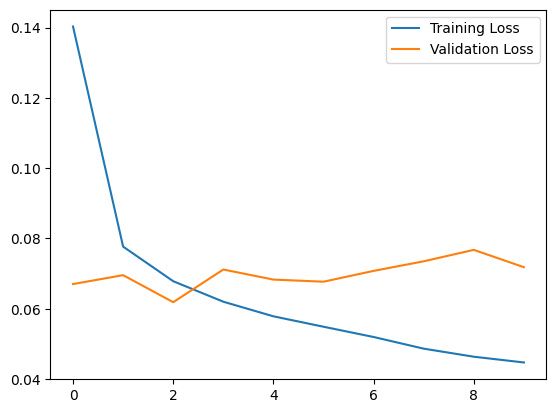

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

## Autoencoder Results

In [ ]:
#Creating testing data with actual and alterted data
X_Test_Clean.shape

(84254, 100)

In [ ]:
#Reconstruction Error with Noisy Data
test_x_predictions = autoencoder.predict(X_test_noisy)
mse = np.mean(np.power(X_test_noisy - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse})
print(Y_test_noisy.nunique())
error_df['True_Class'] =1
print(error_df.head())

2633/2633 [==============================] - 7s 3ms/step
1
        Reconstruction_error  True_Class
16934               0.621218           1
72234               0.621995           1
110709              0.627341           1
13276               0.620189           1
123449              0.627062           1


In [ ]:
X_Test_Clean.head()

,Time,AF_LetdownFlow,AF_LetdownValvePos,AF_MakeupFLow,AF_MakeupValvePos,CC_PumpFlow,CC_PumpInletTemp,CC_PumpOutletTemp,CC_PumpSpeed,CC_PumpTemp,...,TB_OutSteamPress,TB_Speed,TB_SpeedCtrlValvePos,Pad,Pad1,Pad2,Pad3,Pad4,Pad5,Pad6
30038,0.109014,-0.124115,-0.124554,0,-0.034423,0.733428,0.999999,-0.624610,0.733428,0.999999,...,0.017143,-0.423988,0.498110,0,0,0,0,0,0,0
16415,-0.521993,-0.124115,-0.124554,0,-0.735563,0.733391,0.999999,-0.624588,0.733391,0.999999,...,0.017174,-0.423988,0.498068,0,0,0,0,0,0,0
149522,-0.589758,-0.124115,-0.124554,0,-0.664690,-1.299816,0.999999,0.950453,-1.299816,0.999999,...,0.017277,-0.423988,-1.097107,0,0,0,0,0,0,0
51874,1.120442,-0.124115,-0.124554,0,1.089417,0.733432,0.999999,-0.624612,0.733432,0.999999,...,0.017140,-0.423988,0.498113,0,0,0,0,0,0,0
75555,2.217329,-0.124115,-0.124554,0,1.134588,0.733432,0.999999,-0.624612,0.733432,0.999999,...,0.017139,-0.423988,0.498103,0,0,0,0,0,0,0


In [ ]:
#Reconstruction Error with Clean Data
test_x_predictions_clean = autoencoder.predict(X_Test_Clean)
mse = np.mean(np.power(X_Test_Clean - test_x_predictions_clean, 2), axis=1)
error_dfclean = pd.DataFrame({'Reconstruction_error': mse})
print(Y_test_noisy.nunique())
error_dfclean['True_Class'] =Y_Test_Clean
print(error_dfclean.head())

2633/2633 [==============================] - 3s 1ms/step
1
        Reconstruction_error  True_Class
30038               0.000533           0
16415               0.000603           0
149522              0.017786           0
51874               0.000266           0
75555               0.000070           0


In [ ]:
print(X_Test_Clean.shape)
print(X_test_noisy.shape)
frames=[X_Test_Clean, X_test_noisy]
X_test_Combo= pd.concat(frames)
print(X_test_Combo.shape)
print(Y_Test_Clean.shape)
print(Y_test_noisy.shape)
frames_2=[Y_Test_Clean,Y_test_noisy]
Y_test_Combo= pd.concat(frames_2)
print(Y_test_Combo.shape)

(84254, 100)
(84255, 100)
(168509, 100)
(84254,)
(84255,)
(168509,)


In [ ]:
X_test_Combo

,Time,AF_LetdownFlow,AF_LetdownValvePos,AF_MakeupFLow,AF_MakeupValvePos,CC_PumpFlow,CC_PumpInletTemp,CC_PumpOutletTemp,CC_PumpSpeed,CC_PumpTemp,...,TB_OutSteamPress,TB_Speed,TB_SpeedCtrlValvePos,Pad,Pad1,Pad2,Pad3,Pad4,Pad5,Pad6
30038,0.109014,-0.124115,-0.124554,0.00000,-0.034423,0.733428,0.999999,-0.624610,0.733428,0.999999,...,0.017143,-0.423988,0.498110,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
16415,-0.521993,-0.124115,-0.124554,0.00000,-0.735563,0.733391,0.999999,-0.624588,0.733391,0.999999,...,0.017174,-0.423988,0.498068,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
149522,-0.589758,-0.124115,-0.124554,0.00000,-0.664690,-1.299816,0.999999,0.950453,-1.299816,0.999999,...,0.017277,-0.423988,-1.097107,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
51874,1.120442,-0.124115,-0.124554,0.00000,1.089417,0.733432,0.999999,-0.624612,0.733432,0.999999,...,0.017140,-0.423988,0.498113,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75555,2.217329,-0.124115,-0.124554,0.00000,1.134588,0.733432,0.999999,-0.624612,0.733432,0.999999,...,0.017139,-0.423988,0.498103,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21844,-0.271716,-0.125305,-0.125744,-0.00119,-0.451798,0.881032,0.998809,-0.695684,0.881032,0.998809,...,0.015949,2.357267,0.636882,-0.00119,-0.00119,-0.00119,-0.00119,-0.00119,-0.00119,-0.00119
15534,-0.563990,-0.125305,-0.125744,-0.00119,-0.779805,0.881027,0.998809,-0.695681,0.881027,0.998809,...,0.015956,2.357267,0.636878,-0.00119,-0.00119,-0.00119,-0.00119,-0.00119,-0.00119,-0.00119
19385,-0.385615,-0.125305,-0.125744,-0.00119,-0.583895,0.732217,0.998809,-0.625787,0.732217,0.998809,...,0.015968,-0.425178,0.496892,-0.00119,-0.00119,-0.00119,-0.00119,-0.00119,-0.00119,-0.00119
189339,-0.406505,-0.125305,-0.125744,-0.00119,-1.173460,-2.111400,0.998809,2.464841,-2.111400,0.998809,...,0.016031,-0.425178,-2.170962,-0.00119,-0.00119,-0.00119,-0.00119,-0.00119,-0.00119,-0.00119


In [ ]:
#Calculate Reconstruction Error with Both Clean and Altered Data.
test_x_predictions = autoencoder.predict(X_test_Combo)
mse = np.mean(np.power(X_test_Combo - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse})
print(Y_test_noisy.nunique())
error_df['True_Class'] =Y_test_Combo
print(error_df.head())

5266/5266 [==============================] - 6s 1ms/step
1
        Reconstruction_error  True_Class
30038               0.000533           0
16415               0.000603           0
149522              0.017786           0
51874               0.000266           0
75555               0.000070           0


In [ ]:
threshold = 0.3 # currently eyeballing from normal/altered graphs below
print("Threshold: ", threshold)

Threshold:  0.3


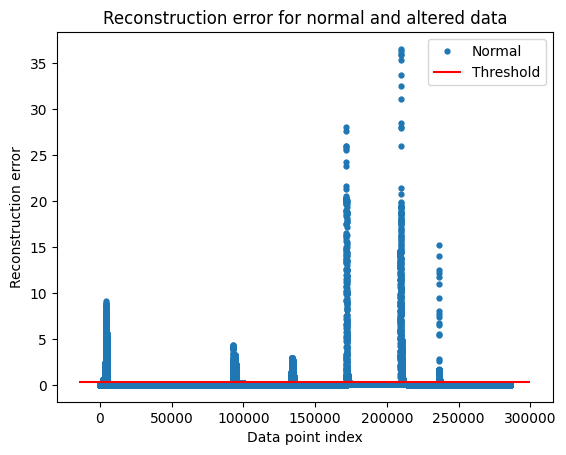

In [ ]:
#Visualize Reconstruction Error
threshold_fixed = threshold
groups = error_dfclean.groupby('True_Class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Altered Data" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and altered data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

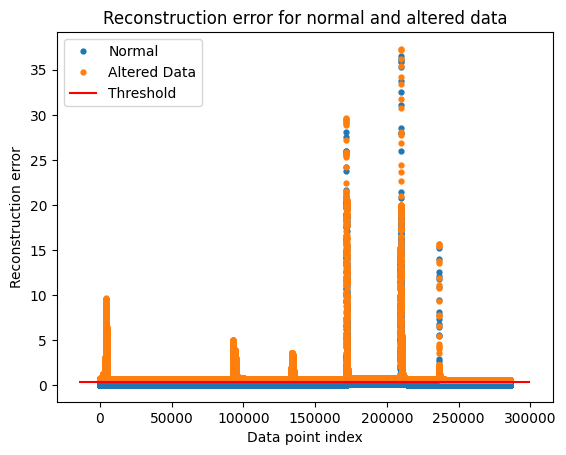

In [ ]:
#Visualize Reconstruction Error
threshold_fixed = threshold
groups = error_df.groupby('True_Class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Altered Data" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and altered data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
threshold_fixed =threshold
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
y_true=Y_test_Combo
print(y_true.head())

30038     0
16415     0
149522    0
51874     0
75555     0
Name: 105, dtype: int64


The accuracy shown below tells us how successful out autoencoder was in detecting anomalies, which in this case is our trojaned data. The recall tells us how many trojaned data were classified as altered data.

In [ ]:
# print Accuracy, precision and recall
acc = accuracy_score(y_true, pred_y) * 100
ps = precision_score(y_true, pred_y) * 100
rs = recall_score(y_true, pred_y) * 100
f1 = f1_score(y_true, pred_y) * 100
print("Threshold: ", threshold)
print('Accuracy of this model is:', acc)
print('Precision of this model is:', ps)
print('Recall of this model is:', rs)
print('F1 of this model is:', f1)

Threshold:  0.3
Accuracy of this model is: 98.08318843503908
Precision of this model is: 96.3079385037435
Recall of this model is: 100.0
F1 of this model is: 98.11925002911379


Confusion matrix, without normalization
[[81024  3230]
 [    0 84255]]


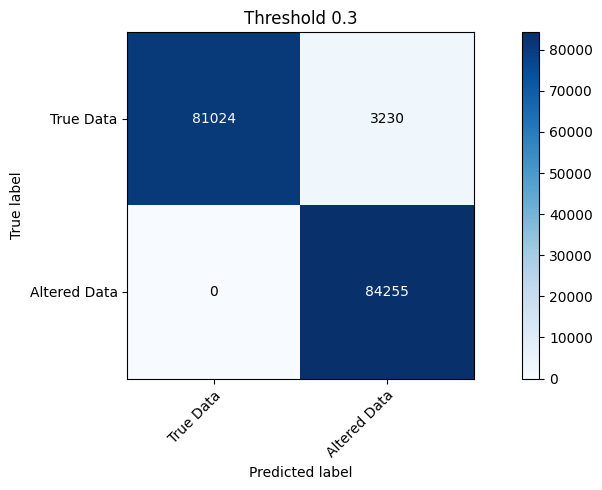

In [ ]:
#Visualization of Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, pred_y)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,5))
    fig.set(dpi=100)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label',

          )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names=['True Data', 'Altered Data']
plot_confusion_matrix(y_true, pred_y, classes=class_names,
                      title='Threshold 0.3')

plt.savefig('test.png', bbox_inches='tight')

The confusion matrix allows us to see how our data was classified. We want a low number of altered data being classified as true data. In our case, we do not want any trojaned data (altered) being classified as benign (true).